# T-Maze Task

The T-Maze task is a classic spatial navigation, learning, and decision-making problem where an agent (here, a rat) must navigate through a T-shaped maze. The agent starts at the bottom of the T and must navigate to one of two goal locations at the ends of the top arms of the T. One arm contains a reward, and the other contains a punishment. 

### Initial Setup
To run this notebook, it's recommended to use a virtual environment. You can refer to [this guide](https://packaging.python.org/en/latest/guides/installing-using-pip-and-virtual-environments/) to learn how to set up a virtual environment.

Then, install the current repo as a package in editable mode by running the following command in your terminal:
```bash
pip install -e .
```

And then, install mediapy by running the following command in your terminal:
```bash
pip install mediapy
```

In [1]:
# a way to edit and run code and see the effects in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

# importing necessary libraries
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import mediapy as media
from jax import random as jr
from pymdp.envs import TMaze

### Creating the Environment

You can alter the number of environments to run in parallel by changing the `batch_size` variable.

Please look at at the TMaze class in `pymdp/envs/tmaze.py` to understand how the parameters of the environment are defined.

In [2]:
batch_size = 4 # number of environments to run in parallel
env = TMaze(batch_size=batch_size) # initializing the environment

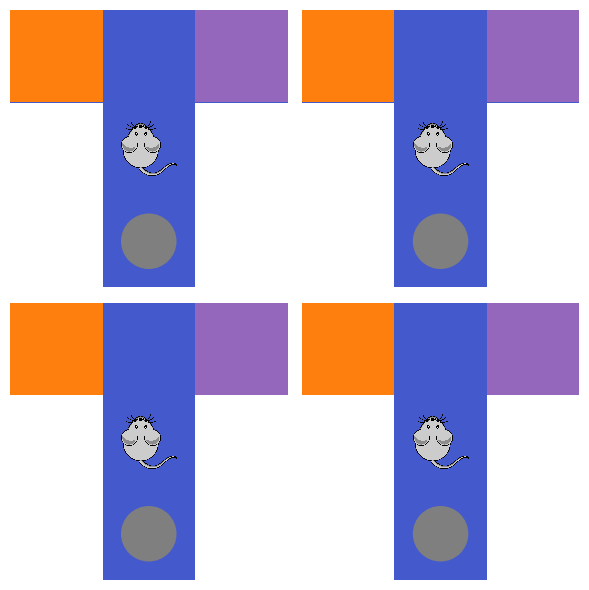

In [3]:
key = jr.PRNGKey(1) # random key for generating random numbers
keys = jr.split(key, 1 + batch_size) # splitting the key into 1 + batch_size keys
key = keys[0] # saving the first key for later use
o, env = env.reset(keys[1:]) # resetting the environment and obtaining initial observations
env.render()

In [4]:
# plt.imshow(env.params["A"][0][0, ...])
# plt.imshow(env.params["A"][1][0, 0, ...])
# plt.imshow(env.params["A"][1][0, 2, ...])
# plt.imshow(env.params["A"][1][0, 1, ...])

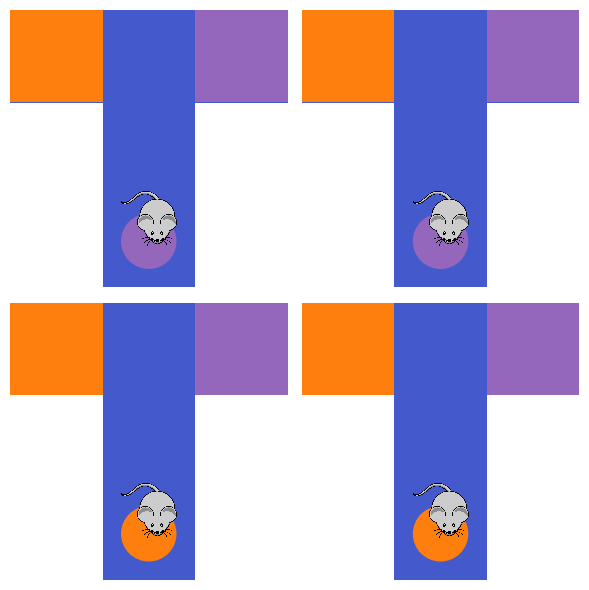

In [5]:
keys = jr.split(key, batch_size + 1)
key = keys[0]
o, env = env.step(keys[1:], jnp.array([[3, 0]] * batch_size))
env.render()

# print(o)

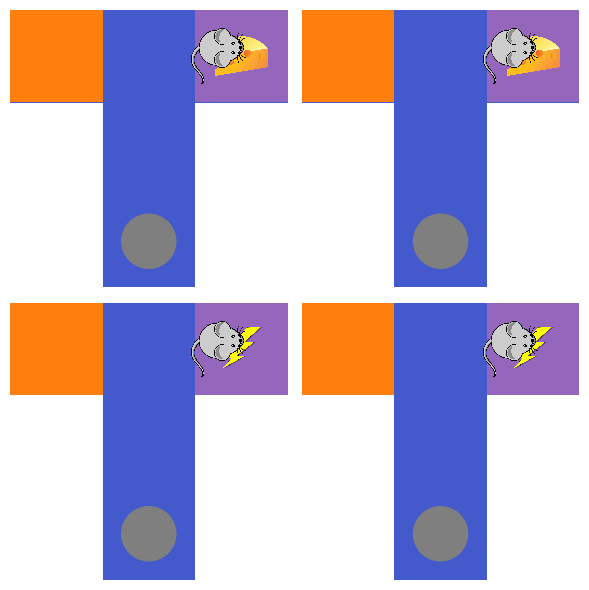

In [6]:
keys = jr.split(key, batch_size + 1)
key = keys[0]
o, env = env.step(keys[1:], jnp.array([[2, 0]] * batch_size))
env.render()

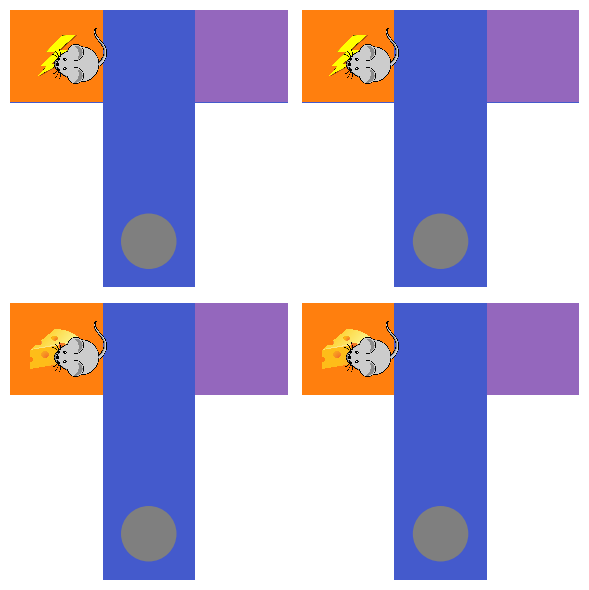

In [7]:
keys = jr.split(key, batch_size + 1)
key = keys[0]
o, env = env.step(keys[1:], jnp.array([[1, 0]] * batch_size))
env.render()

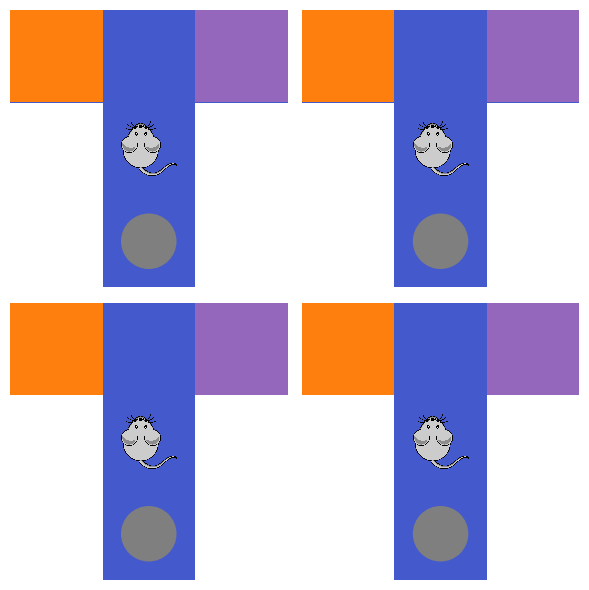

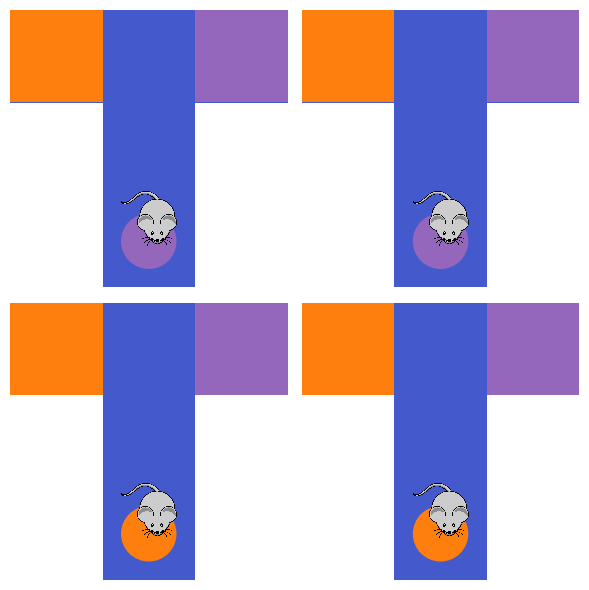

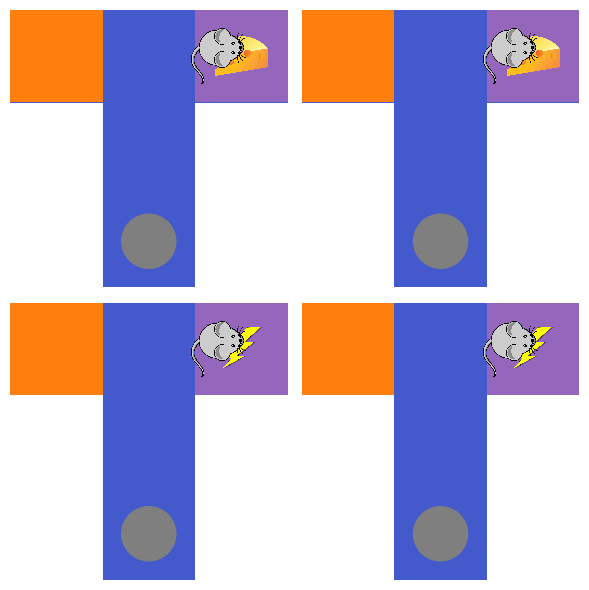

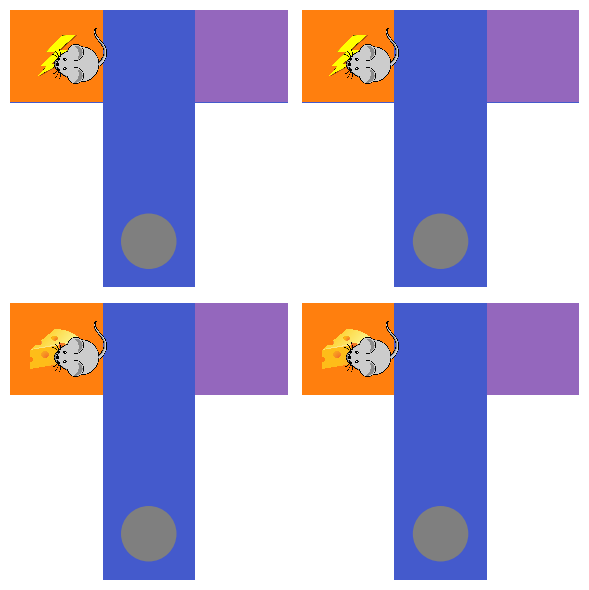

"<source src=""data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAAyttZGF0AAACfwYF//973EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xIHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByYz1jcXAgbWJ0cmVlPTAgcXA9MjAgaXBfcmF0aW89MS40MCBwYl9yYXRpbz0xLjMwIGFxPTAAgAAAAGNliIQA//70oPgUz6FLysxWvdiImDlA4OycM4dgAAADAAADAABkJSorU/j2GkAAAAMBMABTAiwWkPkOwNUPAUMdYpxACBAAAAMAAAMAAAMAAAMAAAMAAAMAAAMAAAMAAAMABxUAAAAQQZojbH/kQAAAAwAAAwAEnAAAAA5BnkF4rwAAAwAAAwABvQAAAA8BnmJqSf8AAAMAAAMAAf4AAANRbW9vdgAAAGxtdmhkAAAAAAAAAAAAAAAAAAAD6AAAD6AAAQAAAQAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAnx0cmFrAAAAXHRraGQAAAADAAAAAAAAAAAAAAABAAAAAAAAD6AAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAoAAAAHgAAAAAAAkZWR0cwAAABxlbHN0AAAAAAAAAAEAAA+gAACAAAABAAAAAAH0bWRpYQAAACBtZGhkAAAAAAAAAAAAAAAAAABAAAABAABVxAAAAAAALWhkbHIAAAAAAAAAAHZpZGUAAAAAAAAAAAAAAABWaWRlb0hhbmRsZXIAAAABn21pbmYAAAAUdm1oZAAAAAEAAAAAAAAAAAAAACRkaW5mAAAAHGRyZWYAAAAAAAAAAQAAAAx1cmwgAAAAAQAAAV9zdGJsAAAAr3N0c2QAAAAAAAAAAQAAAJ9hdmMxAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAoAB4ABIAAAASAAAAAAAAAABFUxhdmM2MS4xOS4xMDAgbGlieDI2NAAAAAAAAAAAAAAAGP//AAAANWF2Y0MBZAAW/+EAGGdkABas2UCgPaEAAAMAAQAAAwACDxYtlgEABmjr4bLIsP34+AAAAAAUYnRydAAAAAAAAAZGAAAGRgAAABhzdHRzAAAAAAAAAAEAAAAEAABAAAAAABRzdHNzAAAAAAAAAAEAAAABAAAAKGN0dHMAAAAAAAAAAwAAAAEAAIAAAAAAAQABAAAAAAACAABAAAAAABxzdHNjAAAAAAAAAAEAAAABAAAABAAAAAEAAAAkc3RzegAAAAAAAAAAAAAABAAAAuoAAAAUAAAAEgAAABMAAAAUc3RjbwAAAAAAAAABAAAAMAAAAGF1ZHRhAAAAWW1ldGEAAAAAAAAAIWhkbHIAAAAAAAAAAG1kaXJhcHBsAAAAAAAAAAAAAAAALGlsc3QAAAAkqXRvbwAAABxkYXRhAAAAAQAAAABMYXZmNjEuNy4xMDA="" type=""video/mp4""/> This browser does not support the video tag."


RuntimeError: Error writing 'tmaze_demo.gif': [gif @ 0x11d2049a0] gif muxer supports only codec gif for type video
[out#0/gif @ 0x11d2048e0] Could not write header (incorrect codec parameters ?): Invalid argument
[vf#0:0 @ 0x11d205ea0] Error sending frames to consumers: Invalid argument
[vf#0:0 @ 0x11d205ea0] Task finished with error code: -22 (Invalid argument)
[vf#0:0 @ 0x11d205ea0] Terminating thread with return code -22 (Invalid argument)
[out#0/gif @ 0x11d2048e0] Nothing was written into output file, because at least one of its streams received no packets.


In [8]:
import mediapy as media
import numpy as np
import matplotlib.pyplot as plt

# Function to get image array from matplotlib figure
def get_fig_array():
    # Get current figure
    fig = plt.gcf()
    fig.canvas.draw()
    # Use buffer_rgba instead of deprecated tostring_rgb
    buffer = fig.canvas.buffer_rgba()
    data = np.asarray(buffer)
    # Convert RGBA to RGB
    data = data[:, :, :3]
    return data

# Reset environment and collect initial frame
key = jr.PRNGKey(1)
keys = jr.split(key, 1 + batch_size)
key = keys[0]
o, env = env.reset(keys[1:])
env.render()  # This displays the figure
frames = [get_fig_array()]
plt.close()

# Define action sequence
actions = [
    jnp.array([[3, 0]] * batch_size),  # to cue
    jnp.array([[2, 0]] * batch_size),  # to right
    jnp.array([[1, 0]] * batch_size),  # to left
]

# Collect frames for each action
for action in actions:
    keys = jr.split(key, batch_size + 1)
    key = keys[0]
    o, env = env.step(keys[1:], action)
    env.render()  # This displays the figure
    frames.append(get_fig_array())
    plt.close()

# Convert frames to numpy array
frames = np.array(frames)

# Display animation in notebook
media.show_video(frames, fps=1)

# Save as gif (optional)
media.write_video('tmaze_demo.gif', frames, fps=1)